In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys

from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb

%matplotlib inline

In [2]:
# Load data
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz')
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

In [3]:
test['date_block_num'] = train['date_block_num'].max()+1

In [4]:
test = test[['date_block_num', 'shop_id', 'item_id']]

In [5]:
item_price = train.groupby(['item_id'])['item_price'].agg(['mean', 'count', 'min', 'max', 'std'])

In [6]:
item_price['diff'] = item_price['max']-item_price['min']
item_price.head()

,mean,count,min,max,std,diff
item_id,,,,,,
0,58.0,1,58.0,58.0,NaN,0.0
1,4490.0,6,4490.0,4490.0,0.000000,0.0
2,58.0,2,58.0,58.0,0.000000,0.0
3,79.0,2,58.0,100.0,29.698485,42.0
4,58.0,1,58.0,58.0,NaN,0.0


In [7]:
item_price.sort_values(by=['std', 'count'], axis=0, ascending=False, inplace=True)

In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [12]:
x = train.copy()

In [13]:
x.sort_values(by=['date'], axis=0, inplace=True, ascending=True)

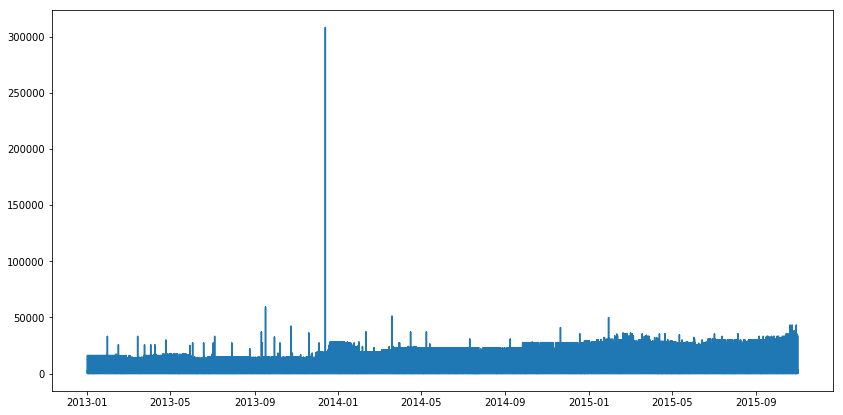

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(x.date, x.item_price)

### Join train and test

In [15]:
x = train.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day', 'item_price']].agg(['sum', 'mean', 'std', 'min', 'max'])

In [16]:
x = x[[('item_cnt_day', 'sum'), ('item_price', 'mean'), ('item_price', 'std')]]

In [17]:
x.head()

item_cnt_day item_price         
                                        sum       mean      std
date_block_num shop_id item_id                                 
0              0       32               6.0      221.0  0.00000
                       33               3.0      347.0  0.00000
                       35               1.0      247.0      NaN
                       43               1.0      221.0      NaN
                       51               2.0      128.5  2.12132

In [18]:
x.fillna(0, inplace=True)

In [19]:
x.columns = ['cnt_sum', 'price_mean', 'price_std']

In [20]:
x = x.reset_index()

In [21]:
x = pd.concat((x, test))

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [22]:
x = x[['date_block_num', 'shop_id', 'item_id', 'price_mean', 'price_std', 'cnt_sum']]

In [23]:
x.head()

,date_block_num,shop_id,item_id,price_mean,price_std,cnt_sum
0,0,0,32,221.0,0.00000,6.0
1,0,0,33,347.0,0.00000,3.0
2,0,0,35,247.0,0.00000,1.0
3,0,0,43,221.0,0.00000,1.0
4,0,0,51,128.5,2.12132,2.0


In [24]:
x = pd.merge(x, shop, how='left')

In [25]:
x = pd.merge(x, item, how='left')

In [26]:
x.head()

,date_block_num,shop_id,item_id,price_mean,price_std,cnt_sum,City,Type,Name,item_name_translated,item_cat1,item_cat2
0,0,0,32,221.0,0.00000,6.0,Yakutsk,Shop,"Ordzhonikidze, 56 francs",1+1,Cinema,DVD
1,0,0,33,347.0,0.00000,3.0,Yakutsk,Shop,"Ordzhonikidze, 56 francs",1+1 (BD),Cinema,Blu-Ray
2,0,0,35,247.0,0.00000,1.0,Yakutsk,Shop,"Ordzhonikidze, 56 francs",10 YEARS LATER,Cinema,DVD
3,0,0,43,221.0,0.00000,1.0,Yakutsk,Shop,"Ordzhonikidze, 56 francs",100 MILLION EURO,Cinema,DVD
4,0,0,51,128.5,2.12132,2.0,Yakutsk,Shop,"Ordzhonikidze, 56 francs",100 best works of classics (mp3-CD) (Digipack),Music,MP3


In [27]:
x.tail()

,date_block_num,shop_id,item_id,price_mean,price_std,cnt_sum,City,Type,Name,item_name_translated,item_cat1,item_cat2
1823319,34,45,18454,NaN,NaN,NaN,Samara,TC,ParkHaus,Sat. Union 55,Music,CD of local production
1823320,34,45,16188,NaN,NaN,NaN,Samara,TC,ParkHaus,Board game Nano Curling,Gifts,Board Games
1823321,34,45,15757,NaN,NaN,NaN,Samara,TC,ParkHaus,NOVIKOV ALEXANDER New collection,Music,CD of local production
1823322,34,45,19648,NaN,NaN,NaN,Samara,TC,ParkHaus,TEREM - TEREMOK sb.m / f (Region),Cinema,DVD
1823323,34,45,969,NaN,NaN,NaN,Samara,TC,ParkHaus,3 DAYS ON MURDER (BD),Cinema,Blu-Ray


### Sales (counts) per City per Month

In [28]:
u = x.groupby(['Type', 'date_block_num'])['cnt_sum'].sum()

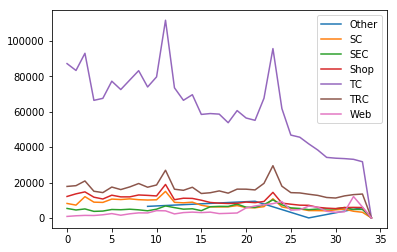

In [29]:
for t in u.index.levels[0]:
    plt.plot(u[t].index, u[t], label=t)
plt.legend()

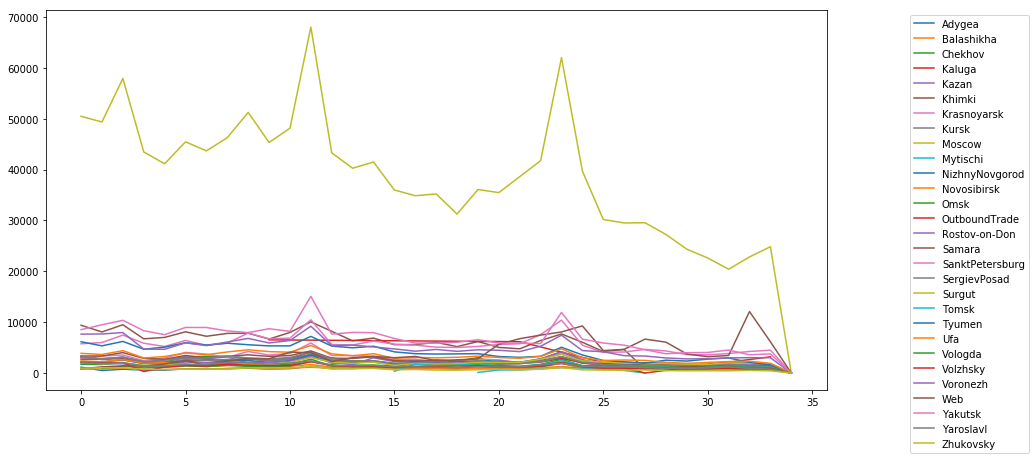

In [30]:
u = x.groupby(['City', 'date_block_num'])['cnt_sum'].sum()
plt.figure(figsize=(14, 7))
for t in u.index.levels[0]:
    plt.plot(u[t].index, u[t], label=t)
plt.legend(bbox_to_anchor=[1.1, 1])

In [31]:
le = LabelEncoder()

In [32]:
x.drop(['Name', 'item_name_translated', 'price_mean', 'price_std'], axis=1, inplace=True)

In [33]:
x['City'] = le.fit_transform(x['City'])
x['Type'] = le.fit_transform(x['Type'])
x['item_cat1'] = le.fit_transform(x['item_cat1'])

In [34]:
x['item_cat2'] = x['item_cat2'].apply(lambda x: str(x))

In [35]:
x['item_cat2'] = le.fit_transform(x['item_cat2'])

In [36]:
cols = ['City', 'Type', 'item_cat1', 'item_cat2']
for c in cols:
    freq = x[c].value_counts()/x[c].value_counts().sum()
    x[c+'_freq'] = x[c].map(freq)
    rank = pd.DataFrame(freq)
    rank[c] = ss.rankdata(freq)
    rank = rank.to_dict()[c]
    x[c+'_rank'] = x[c].map(rank)

In [37]:
x.head()

,date_block_num,shop_id,item_id,cnt_sum,City,Type,item_cat1,item_cat2,City_freq,City_rank,Type_freq,Type_rank,item_cat1_freq,item_cat1_rank,item_cat2_freq,item_cat2_rank
0,0,0,32,6.0,26,3,3,23,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.202064,62.0
1,0,0,33,3.0,26,3,3,9,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.081439,60.0
2,0,0,35,1.0,26,3,3,23,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.202064,62.0
3,0,0,43,1.0,26,3,3,23,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.202064,62.0
4,0,0,51,2.0,26,3,12,36,0.063746,28.0,0.094581,5.0,0.187504,22.0,0.015857,48.0


In [38]:
cnt = x.groupby('date_block_num')['cnt_sum'].sum()

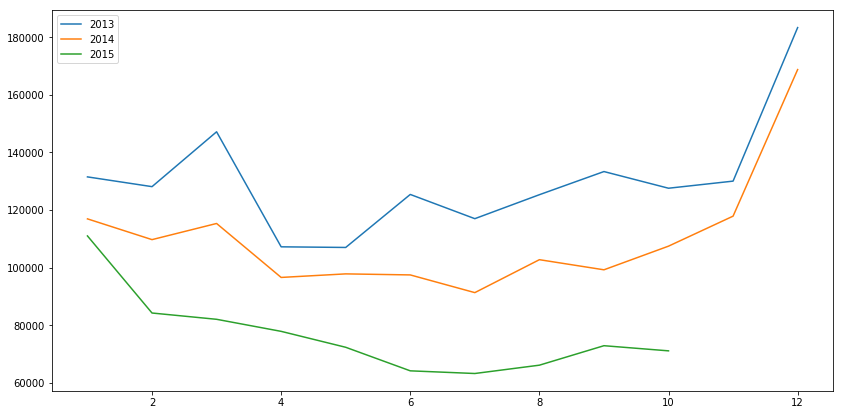

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 13), cnt[:12], label=2013)
plt.plot(np.arange(1, 13), cnt[12:24], label=2014)
plt.plot(np.arange(1, 11), cnt[24:-1], label=2015)
plt.legend()

In [40]:
x['month'] = x['date_block_num']%12

In [41]:
x.head()

,date_block_num,shop_id,item_id,cnt_sum,City,Type,item_cat1,item_cat2,City_freq,City_rank,Type_freq,Type_rank,item_cat1_freq,item_cat1_rank,item_cat2_freq,item_cat2_rank,month
0,0,0,32,6.0,26,3,3,23,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.202064,62.0,0
1,0,0,33,3.0,26,3,3,9,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.081439,60.0,0
2,0,0,35,1.0,26,3,3,23,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.202064,62.0,0
3,0,0,43,1.0,26,3,3,23,0.063746,28.0,0.094581,5.0,0.317816,23.0,0.202064,62.0,0
4,0,0,51,2.0,26,3,12,36,0.063746,28.0,0.094581,5.0,0.187504,22.0,0.015857,48.0,0


In [42]:
# number of zero (shop, item) pairs every month
cnt0 = pd.Series(x[x['cnt_sum']==0].groupby('date_block_num')['cnt_sum'].count())
cnt0[34] = 0
x['cnt_zero_-1m'] = x['date_block_num'].map(cnt0.shift(1))

In [43]:
# u = x[['date_block_num', 'shop_id', 'item_id', 'cnt_sum']].sort_values(['shop_id', 'item_id', 'date_block_num'])

In [44]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

NameError: name 'train_cleaned_df' is not defined